# Advanced Plotting: Beyond matplotlib

Alright, so our prior charts were plotted using `matplotlib` which helps us see the data, but the charts don't look amazing and aren't interactive at all. What other options do we have? [seaborn](https://seaborn.pydata.org/index.html) is a wrapper the top of `matplotlib` that makes much prettier plots (with a ton of statistical plotting capabilities) and [plotly](https://plot.ly/) is a great cross-platform plotting liberary that we can easil set up. Below we'll use `seaborn` and `plotly` to make some pretty pictures. 

First, let's import some libraries.

In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline

Since we don't have access to some of the data that we do within JPM, we'll have to generate some data to plot. In this case, we're going to generate an approximation of Russell2k implied volatility and HYG (iTraxx High Yield Bond ETF) prices.

In [2]:
vols = [ 0.3, 0.06 ]
dailyVols = vols / np.sqrt( 252 )
corr = -0.4
covars = [ 
    [ dailyVols[ 0 ] ** 2, dailyVols[ 0 ] * dailyVols[ 1 ] * corr ],
    [ dailyVols[ 0 ] * dailyVols[ 1 ] * corr, dailyVols[ 1 ] ** 2 ]
]
randomSeries = np.random.multivariate_normal( ( 0.001, 0 ), covars, 500 ).T

In [3]:
randomSeries

array([[ 2.40802572e-02, -2.53462124e-02, -1.86681376e-02,
        -4.38788430e-02, -1.15679681e-02,  1.23540506e-03,
        -2.49359223e-02, -1.26073217e-03,  1.49226529e-02,
         1.06340379e-02, -4.66490453e-03,  2.19732215e-02,
         2.25497248e-03, -3.71267294e-02, -2.57040922e-02,
        -3.88100656e-02,  1.29415588e-02,  1.74642392e-02,
         3.76014817e-02, -1.73157599e-02,  4.86531709e-02,
         2.01345019e-03,  9.76835457e-03,  6.02210059e-03,
         1.76115090e-02, -3.55242854e-02,  8.60568884e-03,
        -1.85656782e-03,  2.27472379e-02, -1.84596134e-03,
        -5.32599672e-03,  2.59531203e-02, -1.39947691e-02,
         1.16551837e-02,  2.88796628e-02,  9.05020619e-03,
         1.96931995e-02,  2.09572210e-02, -5.77178883e-03,
        -2.48208493e-02, -1.66152576e-03,  2.81057722e-02,
        -5.38474737e-03, -1.01765064e-02, -5.97084164e-03,
         7.04662783e-03, -8.27279206e-03, -1.01719323e-02,
         1.87707321e-02, -3.15394866e-02, -2.44921044e-0

We've got two return series, but we need to convert them to a time series for what they're meant to represent. 

In [4]:
rtyVol = 0.2 * ( 1 + randomSeries[ 0 ] ).cumprod()
hygPrice = 80 * ( 1 + randomSeries[ 1 ] ).cumprod()

Let's see if they make sense... Often the easiest way to do that is to plot them. Many of the plotting libraries set up to operate / plot a `DataFrame` natively.

In [5]:
df = pd.DataFrame(np.array([rtyVol, hygPrice]).T, columns=["RTY.3m.Proxy.Implied.Vol", "HYG.spot"])

In [6]:
df.head()

,RTY.3m.Proxy.Implied.Vol,HYG.spot
0,0.204816,79.639891
1,0.199625,80.068173
2,0.195898,79.887199
3,0.187302,80.041307
4,0.185136,80.166950


<Axes: >

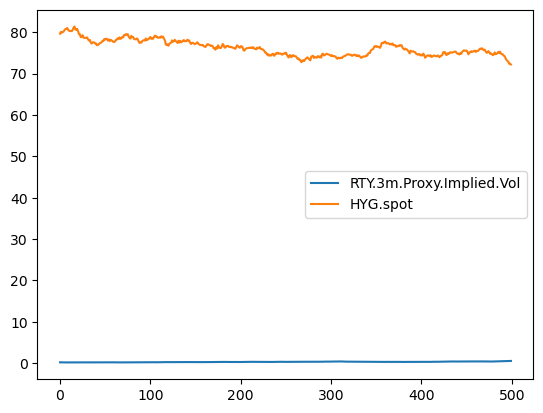

In [7]:
df.plot()

So... problem #1, these two series not similar magnitudes. We need to plot these on difference axes and while we're at it let's make it look a little better. 

In [8]:
plt.style.use('seaborn')
df.plot(secondary_y=["HYG.spot"], legend=True)

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

If we flip around RTY implied vol, we can see this inverse relationship a bit better. 

In [ ]:
df["RTY.3m.Proxy.Implied.Vol"] = df["RTY.3m.Proxy.Implied.Vol"] * -1
df.plot(secondary_y=["HYG.spot"], legend=True)

We can look at the scatter on levels pretty easily with `matplotlib` using `matplotlib.pyplot.scatter`.

In [ ]:
plt.scatter( df[ df.columns[ 0 ] ], df[ df.columns[ 1 ] ] )

It looks like there is a relationship there (there should be, we generated the series with a negative correlation). Let's explore that a bit. As we said before, `seaborn` comes with a bunch of good statistical tools. In fact, it has has quick and easy way to generate a regression plot with `sns.regplot`.

<Axes: xlabel='HYG.spot', ylabel='RTY.3m.Proxy.Implied.Vol'>

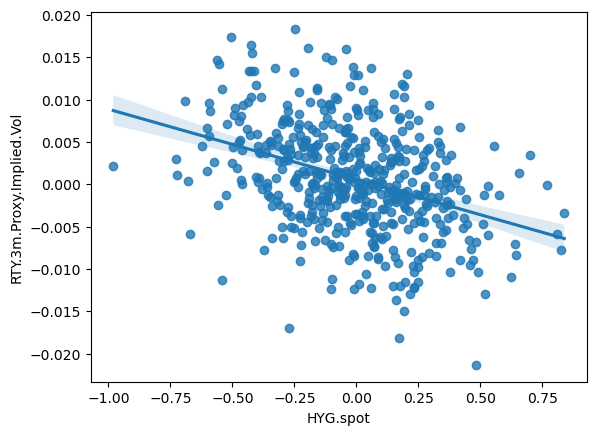

In [12]:
fig, ax = plt.subplots( sharex=True )
sns.regplot( x="HYG.spot", y="RTY.3m.Proxy.Implied.Vol", data=df.diff(), ax=ax )

Unfortunately, the underlying regression data is not exposed in `seaborn`, so we will need to generate it ourselves using `scipy`.

In [13]:
from scipy import stats

diff = df.diff().dropna()
slope, intercept, rvalue, pvalue, stderr = stats.linregress(diff["HYG.spot"], diff["RTY.3m.Proxy.Implied.Vol"])
print( "R^2 = {r:.3f}".format( r=rvalue ) )
print( 'y = {m:.3f}x {sign} {b:.3f}'.format( m=slope, sign="+" if intercept >= 0 else "-", b=abs(intercept) ) )

R^2 = -0.372
y = -0.008x + 0.001


What if I want to interact with the plot.... zoom in, inspect the values, etc. This is where `plotly` shines.

In [14]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.tools as tls
init_notebook_mode(connected=True)

# Here we can convert our matplotlib object to a plotly object
plotlyFig = tls.mpl_to_plotly(fig)

# Add annotation so you have the regression stats
plotlyFig['layout']['annotations'] = [
    dict(
        x=18,
        y=-2,
        showarrow=False,
        text='R^2 = {:.3f}'.format( rvalue )
    ),
    dict(
        x=18,
        y=-2.6,
        showarrow=False,
        text='y = {m:.3f}x {sign} {b:.3f}'.format( m=slope, sign="+" if intercept >= 0 else "-", b=abs(intercept) )
    )
]
iplot(plotlyFig)

/opt/anaconda3/lib/python3.11/site-packages/plotly/matplotlylib/renderer.py:647: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



AttributeError: 'PathCollection' object has no attribute 'get_offset_position'

2d plots are cool but 3d plots.... Below is an example of plotting a vol surface from start to finish.

In [15]:
c = [0.8023,0.814,0.8256,0.8372,0.8488,0.8605,0.8721,0.8837,0.8953,0.907,0.9186,0.9302,0.9419,0.9535,0.9651,0.9767,0.9884,1,1.0116,1.0233,1.0349,1.0465,1.0581,1.0698,1.0814,1.093,1.1047,1.1163,1.1279,1.1395,1.1512,1.1628,1.1744,1.186,1.1977,1.2093]
i = [ dt.datetime(2019,8,2),  dt.datetime(2019,8,9),  dt.datetime(2019,8,16),  dt.datetime(2019,8,23),  dt.datetime(2019,8,30),  dt.datetime(2019,9,6),  dt.datetime(2019,9,20),  dt.datetime(2019,10,18),  dt.datetime(2019,11,15),  dt.datetime(2019,12,20),  dt.datetime(2019,12,31),  dt.datetime(2020,1,17),  dt.datetime(2020,3,20),  dt.datetime(2020,3,31),  dt.datetime(2020,6,19) ]
d = [ [0.4244,0.4016,0.3796,0.3584,0.3381,0.3187,0.3002,0.2827,0.2662,0.2508,0.2363,0.2229,0.2105,0.1991,0.1888,0.1794,0.171,0.1636,0.157,0.1513,0.1465,0.1425,0.1393,0.1368,0.135,0.1338,0.1331,0.1329,0.133,0.1334,0.1341,0.135,0.136,0.1372,0.1384,0.1396],
    [0.4006,0.3777,0.3556,0.3343,0.3139,0.2944,0.2759,0.2583,0.2418,0.2263,0.2118,0.1983,0.1859,0.1745,0.1641,0.1547,0.1463,0.1388,0.1322,0.1265,0.1216,0.1176,0.1143,0.1118,0.11,0.1088,0.1081,0.1078,0.108,0.1084,0.1092,0.1101,0.1112,0.1123,0.1136,0.1149],
    [0.3431,0.3257,0.3089,0.2927,0.277,0.2621,0.2477,0.2341,0.2212,0.2089,0.1974,0.1866,0.1765,0.1671,0.1584,0.1504,0.1431,0.1364,0.1303,0.1248,0.1198,0.1154,0.1116,0.1083,0.1055,0.1032,0.1013,0.0998,0.0986,0.0977,0.0971,0.0966,0.0964,0.0963,0.0963,0.0965],
    [0.3124,0.298,0.284,0.2705,0.2574,0.2449,0.2328,0.2213,0.2104,0.1999,0.1901,0.1807,0.1719,0.1637,0.156,0.1488,0.1421,0.136,0.1304,0.1253,0.1206,0.1165,0.1129,0.1098,0.1072,0.1049,0.1031,0.1015,0.1003,0.0994,0.0988,0.0983,0.098,0.0979,0.0978,0.0979],
    [0.2955,0.283,0.2708,0.259,0.2475,0.2365,0.2259,0.2158,0.206,0.1968,0.1879,0.1795,0.1716,0.1641,0.1571,0.1505,0.1443,0.1385,0.1332,0.1284,0.124,0.1201,0.1167,0.1137,0.1111,0.1089,0.1071,0.1056,0.1044,0.1034,0.1027,0.1022,0.1019,0.1018,0.1017,0.1018],
    [0.2866,0.2752,0.264,0.2532,0.2427,0.2326,0.2228,0.2134,0.2044,0.1958,0.1876,0.1798,0.1724,0.1653,0.1587,0.1524,0.1465,0.141,0.1359,0.1313,0.1271,0.1233,0.12,0.1171,0.1145,0.1124,0.1106,0.1091,0.1079,0.1069,0.1062,0.1057,0.1054,0.1052,0.1051,0.1051],
    [0.2729,0.2632,0.2538,0.2446,0.2357,0.227,0.2187,0.2106,0.2028,0.1954,0.1882,0.1813,0.1748,0.1685,0.1626,0.1569,0.1516,0.1465,0.1418,0.1376,0.1336,0.1301,0.127,0.1242,0.1218,0.1197,0.1179,0.1164,0.1152,0.1143,0.1135,0.113,0.1126,0.1124,0.1122,0.1122],
    [0.2548,0.2473,0.24,0.2329,0.226,0.2192,0.2126,0.2063,0.2001,0.1941,0.1883,0.1827,0.1773,0.1721,0.167,0.1622,0.1576,0.1532,0.149,0.1452,0.1416,0.1383,0.1354,0.1327,0.1303,0.1281,0.1262,0.1246,0.1232,0.122,0.121,0.1202,0.1195,0.119,0.1186,0.1183],
    [0.2482,0.242,0.2359,0.2299,0.2241,0.2184,0.2128,0.2074,0.2021,0.1969,0.1919,0.187,0.1823,0.1777,0.1733,0.169,0.1649,0.1608,0.157,0.1535,0.1501,0.1471,0.1442,0.1415,0.1391,0.1369,0.135,0.1332,0.1316,0.1303,0.1291,0.128,0.1271,0.1263,0.1257,0.1252],
    [0.2331,0.2278,0.2227,0.2176,0.2127,0.2078,0.2031,0.1984,0.1939,0.1895,0.1851,0.1809,0.1768,0.1728,0.1689,0.1652,0.1615,0.158,0.1547,0.1516,0.1486,0.1459,0.1433,0.1409,0.1387,0.1367,0.1349,0.1332,0.1317,0.1303,0.1291,0.128,0.127,0.1261,0.1254,0.1247],
    [0.2313,0.2262,0.2212,0.2163,0.2115,0.2068,0.2022,0.1977,0.1932,0.1889,0.1847,0.1806,0.1766,0.1727,0.1689,0.1653,0.1617,0.1582,0.155,0.152,0.1491,0.1464,0.1438,0.1415,0.1393,0.1373,0.1354,0.1337,0.1322,0.1308,0.1296,0.1284,0.1274,0.1266,0.1258,0.1251],
    [0.2302,0.2253,0.2206,0.216,0.2114,0.2069,0.2026,0.1983,0.1941,0.19,0.186,0.1821,0.1783,0.1745,0.1709,0.1674,0.164,0.1607,0.1576,0.1546,0.1518,0.1492,0.1467,0.1444,0.1423,0.1403,0.1384,0.1367,0.1351,0.1337,0.1324,0.1313,0.1302,0.1293,0.1285,0.1277],
    [0.229,0.2249,0.2209,0.2169,0.213,0.2091,0.2054,0.2017,0.1981,0.1946,0.1911,0.1877,0.1845,0.1812,0.1781,0.175,0.172,0.1691,0.1664,0.1637,0.1611,0.1587,0.1563,0.1541,0.152,0.15,0.148,0.1462,0.1445,0.143,0.1415,0.1401,0.1388,0.1376,0.1365,0.1355],
    [0.2289,0.2249,0.2209,0.2171,0.2133,0.2096,0.2059,0.2023,0.1988,0.1953,0.192,0.1887,0.1855,0.1823,0.1793,0.1763,0.1733,0.1705,0.1678,0.1651,0.1626,0.1602,0.1579,0.1557,0.1535,0.1515,0.1496,0.1478,0.1461,0.1445,0.143,0.1415,0.1402,0.139,0.1379,0.1368],
    [0.2239,0.2207,0.2175,0.2143,0.2112,0.2082,0.2051,0.2022,0.1993,0.1964,0.1936,0.1909,0.1882,0.1855,0.1829,0.1804,0.1779,0.1755,0.1731,0.1708,0.1685,0.1663,0.1642,0.1622,0.1601,0.1582,0.1563,0.1545,0.1527,0.151,0.1494,0.1478,0.1464,0.1449,0.1436,0.1423]
]
df2 = pd.DataFrame(d, columns=c, index=i)

In [16]:
df2.head()

,0.8023,0.8140,0.8256,0.8372,0.8488,0.8605,0.8721,0.8837,0.8953,0.9070,...,1.1047,1.1163,1.1279,1.1395,1.1512,1.1628,1.1744,1.1860,1.1977,1.2093
2019-08-02,0.4244,0.4016,0.3796,0.3584,0.3381,0.3187,0.3002,0.2827,0.2662,0.2508,...,0.1331,0.1329,0.1330,0.1334,0.1341,0.1350,0.1360,0.1372,0.1384,0.1396
2019-08-09,0.4006,0.3777,0.3556,0.3343,0.3139,0.2944,0.2759,0.2583,0.2418,0.2263,...,0.1081,0.1078,0.1080,0.1084,0.1092,0.1101,0.1112,0.1123,0.1136,0.1149
2019-08-16,0.3431,0.3257,0.3089,0.2927,0.2770,0.2621,0.2477,0.2341,0.2212,0.2089,...,0.1013,0.0998,0.0986,0.0977,0.0971,0.0966,0.0964,0.0963,0.0963,0.0965
2019-08-23,0.3124,0.2980,0.2840,0.2705,0.2574,0.2449,0.2328,0.2213,0.2104,0.1999,...,0.1031,0.1015,0.1003,0.0994,0.0988,0.0983,0.0980,0.0979,0.0978,0.0979
2019-08-30,0.2955,0.2830,0.2708,0.2590,0.2475,0.2365,0.2259,0.2158,0.2060,0.1968,...,0.1071,0.1056,0.1044,0.1034,0.1027,0.1022,0.1019,0.1018,0.1017,0.1018


In [17]:
import plotly.graph_objs as go

fig = go.Figure(
    data=[ go.Surface(
        z=df2.values.tolist(),
        y=df2.columns.values,
        x=df2.index.astype(str).values.tolist()
    )],
    layout=dict(
        title = 'Vol Surface', 
        autosize = True,
        width = 900,
        height = 700,
        margin = dict(
            l = 65,
            r = 50,
            b = 65,
            t = 90
        ),
        scene = dict(
            aspectratio = dict(
                x = 1,
                y = 1,
                z = 0.667
            )
        )
    ))

go.FigureWidget(fig)

FigureWidget({
    'data': [{'type': 'surface',
              'uid': 'f110ef89-635b-49c8-b5cc-9465ddd82e40',
 …